In [1]:
from __future__ import annotations

from pathlib import Path
import re

import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
RAW_FILES = [
    "data/original/mdot_series_q010_e000.txt",
    "data/original/mdot_series_q025_e000.txt",
    "data/original/mdot_series_q050_e000.txt",
    "data/original/mdot_series_q100_e000.txt",
    "data/original/mdot_series_q100_e050.txt",
    "data/original/mdot_series_q100_e040.txt",
    "data/original/mdot_series_q100_e030.txt",
    "data/original/mdot_series_q100_e020.txt",
    "data/original/mdot_series_q100_e010.txt",
    "data/original/mdot_series_q100_e060.txt",
    "data/original/mdot_series_q100_e070.txt",
]

N_SEGMENTS        = 20                          # segmentos por serie
SEGMENTS_DIR      = Path("data/segments")
SEGMENTS_DIR.mkdir(parents=True, exist_ok=True)
FLOAT_FMT         = "%.18e"

In [3]:
for raw in RAW_FILES:
    raw_path = Path(raw)
    if not raw_path.exists():
        print(f"⚠️  No se encontró {raw_path} – se omite.")
        continue

    df_raw = pd.read_csv(raw_path, delim_whitespace=True, header=None)
    rows_per_seg = len(df_raw) // N_SEGMENTS

    for i in range(N_SEGMENTS):
        start = i * rows_per_seg
        end   = (i + 1) * rows_per_seg if i < N_SEGMENTS - 1 else len(df_raw)
        seg_df = df_raw.iloc[start:end]

        seg_name = raw_path.stem + f"_seg{i+1:02d}" + raw_path.suffix
        seg_df.to_csv(
            SEGMENTS_DIR / seg_name,
            sep=" ",
            header=False,
            index=False,
            float_format=FLOAT_FMT,
        )


In [4]:
PATTERN = "*_seg??.txt"
COLUMN_TIME = "time"
COL_PRIMARY = "acre_rate_primary"
COL_SECOND  = "acre_rate_secondary"
COL_MW      = "acre_rate_mass_weighted"

In [5]:
def _parse_fname(fname: str) -> tuple[float | None, float | None, int | None]:
    """Extrae q, e y número de segmento del nombre de archivo."""
    m = re.search(r"q(\d+)_e(\d+)_seg(\d+)", fname)
    if not m:
        return None, None, None
    q = int(m.group(1)) / 100.0
    e = int(m.group(2)) / 100.0
    s = int(m.group(3))
    return q, e, s


frames: list[pd.DataFrame] = []
for f in sorted(SEGMENTS_DIR.glob(PATTERN)):
    q_val, e_val, seg_id = _parse_fname(f.name)
    if q_val is None:
        print(f"Nombre no coincide: {f.name} – omitido.")
        continue

    df = pd.read_csv(
        f,
        delim_whitespace=True,
        header=None,
        names=[COLUMN_TIME, COL_PRIMARY, COL_SECOND],
    )
    df["q"], df["e"], df["seg"] = q_val, e_val, seg_id

    # peso por masa – (BH₁ másivo, BH₂ menosivo)
    w1 = 1 / (1 + q_val)
    w2 = q_val / (1 + q_val)
    df[COL_MW] = w1 * df[COL_PRIMARY].abs() + w2 * df[COL_SECOND].abs()

    q_tag  = f"{int(round(q_val * 100)):03d}"
    e_tag  = f"{int(round(e_val * 100)):03d}"
    seg_tag = f"{seg_id:02d}"
    df["id"] = f"{q_tag}_{e_tag}_{seg_tag}"

    frames.append(df)

all_data = pd.concat(frames, ignore_index=True)

all_data = all_data[~all_data["seg"].isin({1, 2})]

CSV_CLEAN = Path("data/data_csv/all_data_clean.csv")
CSV_CLEAN.parent.mkdir(parents=True, exist_ok=True)
all_data.to_csv(CSV_CLEAN, index=False)

In [6]:
all_data

time  acre_rate_primary  acre_rate_secondary    q    e  seg  \
10000     200.015132          -0.003976            -0.011028  0.1  0.0    3   
10001     200.030826          -0.003974            -0.011079  0.1  0.0    3   
10002     200.046532          -0.003971            -0.011159  0.1  0.0    3   
10003     200.062255          -0.003969            -0.011278  0.1  0.0    3   
10004     200.093726          -0.003959            -0.011499  0.1  0.0    3   
...              ...                ...                  ...  ...  ...  ...   
1100006  1999.922054          -0.001690            -0.012933  1.0  0.7   20   
1100007  1999.954098          -0.001862            -0.014619  1.0  0.7   20   
1100008  1999.969444          -0.001915            -0.015206  1.0  0.7   20   
1100009  1999.984827          -0.002066            -0.015821  1.0  0.7   20   
1100010  2000.011289          -0.003470            -0.019019  1.0  0.7   20   

         acre_rate_mass_weighted          id  
10000                   0.004617  010_000_03  
10001                   0.004620  010_000_03  
10002                   0.004625  010_000_03  
10003                   0.004634  010_000_03  
10004                   0.004644  010_000_03  
...                          ...         ...  
1100006                 0.007312  100_070_20  
1100007                 0.008241  100_070_20  
1100008                 0.008560  100_070_20  
1100009                 0.008943  100_070_20  
1100010                 0.011244  100_070_20  

[990011 rows x 8 columns]

In [7]:
#ruido gaussiano
CSV_NOISY        = Path("data/data_csv/all_data_noisy.csv")
STD_FACTOR       =  0.1 #  20% de σ
RANDOM_SEED: int | None = None  # «None» → ruido distinto en cada ejecución

rng = np.random.default_rng(RANDOM_SEED) if RANDOM_SEED is not None else np.random.default_rng()
noisy_df = pd.read_csv(CSV_CLEAN)

sigma = noisy_df[COL_MW].std(ddof=1)

# Guarda copia limpia y sobre‑escribe la columna con su versión ruidosa
noisy_df[f"{COL_MW}_clean"] = noisy_df[COL_MW]
noise = rng.normal(0.0, STD_FACTOR * sigma, size=len(noisy_df))
noisy_df[COL_MW] = noisy_df[COL_MW] + noise

#eliminar outliers por número de segmento
#noisy_df = noisy_df[~noisy_df["seg"].isin({1, 2})]

#noisy_df.to_csv(CSV_NOISY, index=False)

In [8]:
noisy_df

time  acre_rate_primary  acre_rate_secondary    q    e  seg  \
0        200.015132          -0.003976            -0.011028  0.1  0.0    3   
1        200.030826          -0.003974            -0.011079  0.1  0.0    3   
2        200.046532          -0.003971            -0.011159  0.1  0.0    3   
3        200.062255          -0.003969            -0.011278  0.1  0.0    3   
4        200.093726          -0.003959            -0.011499  0.1  0.0    3   
...             ...                ...                  ...  ...  ...  ...   
990006  1999.922054          -0.001690            -0.012933  1.0  0.7   20   
990007  1999.954098          -0.001862            -0.014619  1.0  0.7   20   
990008  1999.969444          -0.001915            -0.015206  1.0  0.7   20   
990009  1999.984827          -0.002066            -0.015821  1.0  0.7   20   
990010  2000.011289          -0.003470            -0.019019  1.0  0.7   20   

        acre_rate_mass_weighted          id  acre_rate_mass_weighted_clean  
0                      0.004762  010_000_03                       0.004617  
1                      0.004488  010_000_03                       0.004620  
2                      0.004421  010_000_03                       0.004625  
3                      0.004654  010_000_03                       0.004634  
4                      0.004770  010_000_03                       0.004644  
...                         ...         ...                            ...  
990006                 0.007462  100_070_20                       0.007312  
990007                 0.008233  100_070_20                       0.008241  
990008                 0.008524  100_070_20                       0.008560  
990009                 0.008831  100_070_20                       0.008943  
990010                 0.011235  100_070_20                       0.011244  

[990011 rows x 9 columns]


#ponderar columna tiempo(orbita)
noisy_df['time_days'] = noisy_df['time'] * DAYS_PER_ORBIT

# Cada fila cae en un bucket de longitud OBS_FREQ_DAYS.
# Ej.: si OBS_FREQ_DAYS = 7, todos los días 0-6 → bucket 0, 7-13 → bucket 1
noisy_df['bucket'] = (noisy_df['time_days'] // OBS_FREQ_DAYS).astype(int)



In [9]:
DAYS_PER_ORBIT = 300.0   #factor para ponderar orbita (30, 100,300)
OBS_FREQ_DAYS  = 30.0    #frecuencia observacion(1 = diario, 7 = semanal, 15 = quincenal)
# Claves que definen cada serie
clave = ['id']          # ajusta a tu caso

noisy_df['time_days'] = noisy_df['time'] * DAYS_PER_ORBIT
noisy_df['bucket'] = np.floor((noisy_df['time_days'] + 1e-9) / OBS_FREQ_DAYS).astype(int)

df_unique = (
    noisy_df
        .groupby(clave + ['bucket'], as_index=False)
        .median(numeric_only=True)
        .sort_values(clave + ['time_days'])
        #.drop(columns='bucket')
        .reset_index(drop=True)
)



#Conservar 1 fila por bucket
df_unique = (
    noisy_df
    .sort_values('time_days')
    .drop_duplicates(subset='bucket', keep='last') #keep=last para mantener la ultima obs, keep first para la primera
    .reset_index(drop=True)
    .drop(columns='bucket')
)
# df_unique ahora contiene exactamente una observación

In [10]:
df_unique

id  bucket         time  acre_rate_primary  \
0       010_000_03    2000   200.046532          -0.003971   
1       010_000_03    2001   200.141060          -0.003941   
2       010_000_03    2002   200.251149          -0.003895   
3       010_000_03    2003   200.345299          -0.003864   
4       010_000_03    2004   200.455242          -0.003842   
...            ...     ...          ...                ...   
198006  100_070_20   19996  1999.652865          -0.002382   
198007  100_070_20   19997  1999.748086          -0.002034   
198008  100_070_20   19998  1999.840689          -0.001769   
198009  100_070_20   19999  1999.954098          -0.001862   
198010  100_070_20   20000  2000.011289          -0.003470   

        acre_rate_secondary    q    e   seg  acre_rate_mass_weighted  \
0                 -0.011159  0.1  0.0   3.0                 0.004654   
1                 -0.011797  0.1  0.0   3.0                 0.004832   
2                 -0.011635  0.1  0.0   3.0                 0.004759   
3                 -0.010908  0.1  0.0   3.0                 0.004547   
4                 -0.010054  0.1  0.0   3.0                 0.004378   
...                     ...  ...  ...   ...                      ...   
198006            -0.004459  1.0  0.7  20.0                 0.003458   
198007            -0.005470  1.0  0.7  20.0                 0.003918   
198008            -0.008886  1.0  0.7  20.0                 0.005331   
198009            -0.014619  1.0  0.7  20.0                 0.008233   
198010            -0.019019  1.0  0.7  20.0                 0.011235   

        acre_rate_mass_weighted_clean      time_days  
0                            0.004625   60013.959459  
1                            0.004651   60042.318018  
2                            0.004599   60075.344837  
3                            0.004504   60103.589706  
4                            0.004407   60136.572515  
...                               ...            ...  
198006                       0.003398  599895.859511  
198007                       0.003752  599924.425813  
198008                       0.005328  599952.206601  
198009                       0.008241  599986.229356  
198010                       0.011244  600003.386571  

[198011 rows x 11 columns]

In [11]:
filtro_id = df_unique[df_unique['id'] == '100_060_20']

In [12]:
filtro_id

id  bucket         time  acre_rate_primary  \
179009  100_060_20   19000  1900.052839          -0.014509   
179010  100_060_20   19001  1900.147674          -0.015984   
179011  100_060_20   19002  1900.255663          -0.013518   
179012  100_060_20   19003  1900.352451          -0.011233   
179013  100_060_20   19004  1900.450648          -0.009319   
...            ...     ...          ...                ...   
180005  100_060_20   19996  1999.651820          -0.007018   
180006  100_060_20   19997  1999.756720          -0.007312   
180007  100_060_20   19998  1999.846385          -0.007912   
180008  100_060_20   19999  1999.946912          -0.008410   
180009  100_060_20   20000  2000.007754          -0.010016   

        acre_rate_secondary    q    e   seg  acre_rate_mass_weighted  \
179009            -0.003914  1.0  0.6  20.0                 0.009360   
179010            -0.005585  1.0  0.6  20.0                 0.010799   
179011            -0.005176  1.0  0.6  20.0                 0.009587   
179012            -0.004419  1.0  0.6  20.0                 0.007797   
179013            -0.003726  1.0  0.6  20.0                 0.006260   
...                     ...  ...  ...   ...                      ...   
180005            -0.001088  1.0  0.6  20.0                 0.004155   
180006            -0.000943  1.0  0.6  20.0                 0.004148   
180007            -0.000858  1.0  0.6  20.0                 0.004335   
180008            -0.000836  1.0  0.6  20.0                 0.004643   
180009            -0.001541  1.0  0.6  20.0                 0.005765   

        acre_rate_mass_weighted_clean      time_days  
179009                       0.009211  570015.851682  
179010                       0.010675  570044.302130  
179011                       0.009347  570076.698751  
179012                       0.007826  570105.735269  
179013                       0.006523  570135.194286  
...                               ...            ...  
180005                       0.004053  599895.545852  
180006                       0.004127  599927.016065  
180007                       0.004385  599953.915353  
180008                       0.004623  599984.073653  
180009                       0.005778  600002.326204  

[1001 rows x 11 columns]

In [13]:
def plot_segment_by_id_interactive(
    df: pd.DataFrame,
    id: str,
    *,
    save_path: str | None = None,
):
    """Dibuja el segmento correspondiente a `id` en línea interactiva Plotly."""

    subset = df.loc[df["id"] == id].sort_values("time_days")
    if subset.empty:
        raise ValueError(f"ID «{id}» no encontrado en el DataFrame.")

    # ── metadatos para el título ────────────────────────────────────────────
    q_raw, e_raw, seg_raw = subset.loc[:, ["q", "e", "seg"]].iloc[0]

    # q-e pueden venir en 1.00–0.10 o en 100–10; detectamos escala
    is_float = subset["q"].max() <= 10
    q_disp = q_raw if is_float else q_raw / 100.0
    e_disp = e_raw if is_float else e_raw / 100.0

    # asegúrate de que `seg` sea int antes de formatear
    seg_disp = int(round(seg_raw))
    title = f"ID {id}  (q={q_disp:.2f}, e={e_disp:.2f}, seg={seg_disp:02d})"

    # ── gráfico interactivo ────────────────────────────────────────────────
    fig = px.line(
        subset,
        x="time_days",
        y="acre_rate_mass_weighted",
        title=title,
        template="plotly_white",
    )
    fig.update_xaxes(showgrid=True, gridcolor="rgba(0,0,0,0.1)")
    fig.update_yaxes(showgrid=True, gridcolor="rgba(0,0,0,0.1)")
    fig.update_traces(
        hovertemplate="<b>t = %{x:.3f}</b><br>rate = %{y:.3e}<extra></extra>"
    )

    # ── guardado opcional ──────────────────────────────────────────────────
    if save_path:
        out = Path(save_path)
        if out.suffix.lower() == ".html":
            fig.write_html(out)
        else:                               # png, pdf,…
            fig.write_image(out, engine="kaleido", scale=2)
        print(f"✅ Figura guardada en {out}")

    return fig





In [14]:
# Ejemplo de dos segmentos arbitrarios
target_id = "100_050_20"

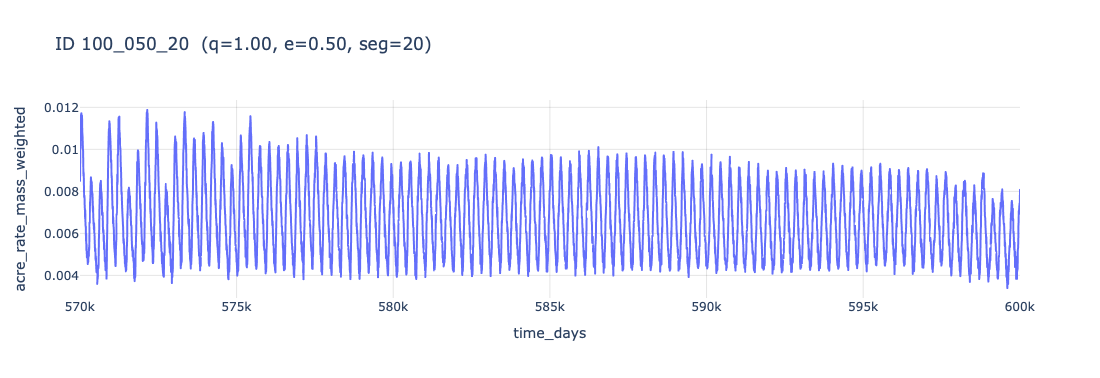

In [15]:
plot_segment_by_id_interactive(noisy_df, id=target_id)

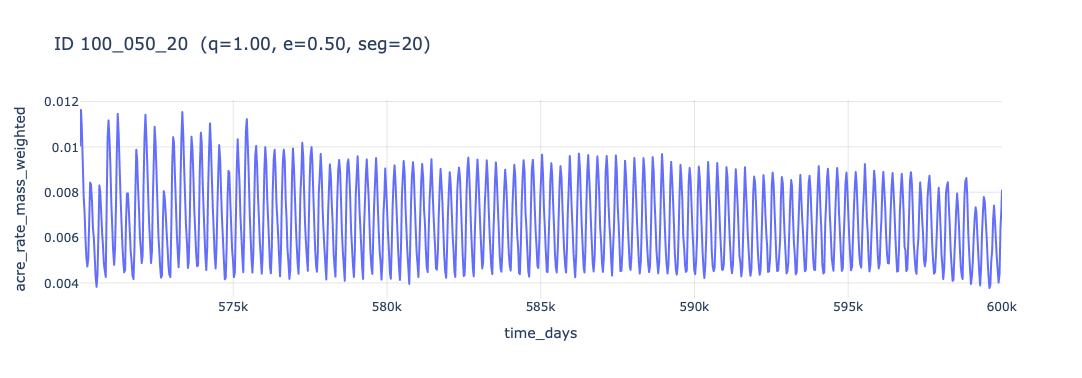

In [16]:
plot_segment_by_id_interactive(df_unique, id=target_id)

In [17]:
def plot_segment_by_id_scatter(df: pd.DataFrame, id: str, *, y: str = "acre_rate_mass_weighted", save_path: str | None = None):
    """Dibuja el segmento correspondiente a `id` como gráfico de dispersión."""
    subset = df.loc[df["id"] == id].sort_values("time_days")
    if subset.empty:
        raise ValueError(f"ID «{id}» no encontrado en el DataFrame.")
    
    # Metadatos para el título
    q_raw, e_raw, seg = subset.loc[:, ["q", "e", "seg"]].iloc[0]
    is_float = subset["q"].max() <= 10
    q_disp = q_raw if is_float else q_raw / 100.0
    e_disp = e_raw if is_float else e_raw / 100.0

    title = f"ID {id}  (q={q_disp:.2f}, e={e_disp:.2f}, seg={int(seg):02d})"
    
    fig = px.scatter(
        subset,
        x="time_days",
        y=y,
        title=title,
        labels={"time_days": "time_days", y: y},
        template="plotly_white"
    )

    fig.update_traces(marker=dict(size=4))

    if save_path:
        fig.write_html(save_path)
    fig.show()

In [18]:
all_data['time_days'] = all_data['time'] * DAYS_PER_ORBIT
all_data['bucket'] = np.floor((all_data['time_days'] + 1e-9) / OBS_FREQ_DAYS).astype(int)


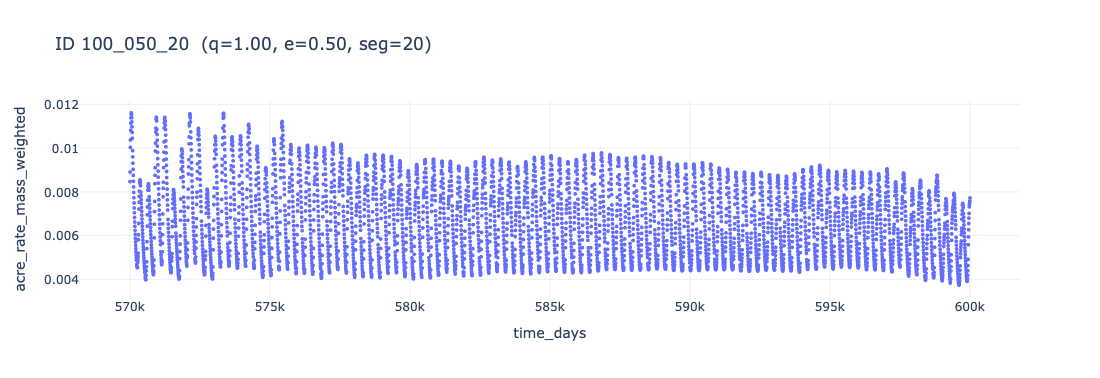

In [19]:

plot_segment_by_id_scatter(all_data, id=target_id)


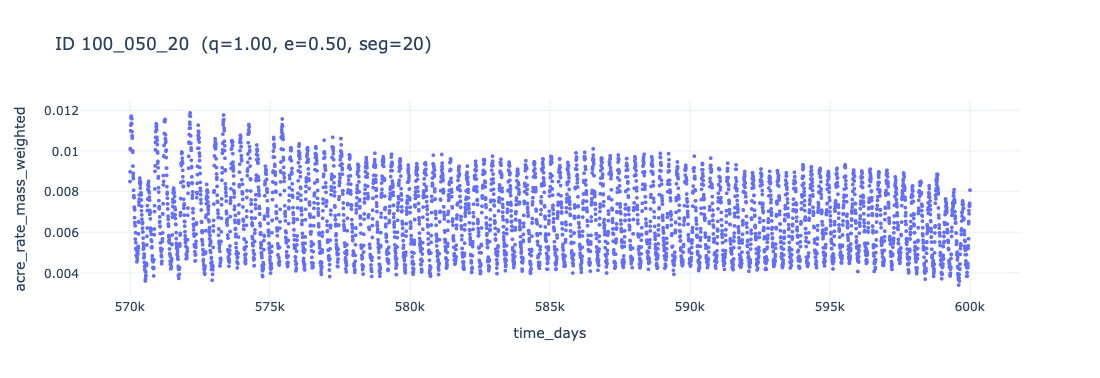

In [20]:
plot_segment_by_id_scatter(noisy_df, id=target_id)


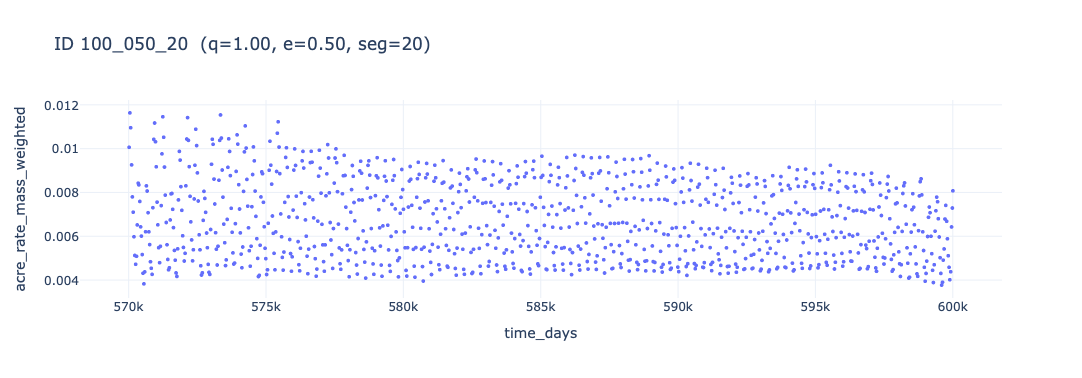

In [21]:
plot_segment_by_id_scatter(df_unique, id=target_id)


In [22]:
import pandas as pd
from typing import List, Optional, Tuple, Union
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_id_across_dfs(
    dfs: List[pd.DataFrame],
    id: str,
    *,
    y: str = "acre_rate_mass_weighted",
    x_range: Optional[Tuple[Union[int, float], Union[int, float]]] = None,
    save_path: Optional[str] = None,
    height_per_plot: int = 300
):
    """
    Dibuja el mismo segmento `id` en cada DataFrame de `dfs`,
    apilando los scatter plots verticalmente.

    Parámetros:
    -----------
    dfs : List[pd.DataFrame]
        Lista de DataFrames con columnas 'id', 'time_days', 'q', 'e', 'seg'.
    id : str
        Identificador del segmento a graficar en todos los dfs.
    y : str, opcional
        Columna para el eje y.
    x_range : tuple (xmin, xmax), opcional
        Límites del eje x.
    save_path : str, opcional
        Ruta para guardar HTML.
    height_per_plot : int
        Altura de cada subplot en píxeles.
    """
    n = len(dfs)
    # Generamos un título para cada subplot (puedes personalizar nombres de dfs)
    titles = [
        "Simulaciones Originales",
        "Ruido Gaussiano",
        "Frecuencia de observacion",
        "Estacionalidad"
    ]


    # Creamos subplots
    fig = make_subplots(
        rows=n, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=titles
    )

    # Añadimos cada serie
    for row, df in enumerate(dfs, start=1):
        subset = df.loc[df["id"] == id].sort_values("time_days")
        fig.add_trace(
            go.Scatter(
                x=subset["time_days"],
                y=subset[y],
                mode="markers",
                marker=dict(size=4),
                showlegend=False
            ),
            row=row, col=1
        )
        fig.update_yaxes(title_text=y, row=row, col=1)

    # Acotar eje x si se pide
    if x_range is not None:
        fig.update_xaxes(range=list(x_range))

    fig.update_layout(
        height=height_per_plot * n,
        template="plotly_white",
        title_text=f"Evolución de datos preparados para curva {id}",
        title_x=0.5
    )

    if save_path:
        fig.write_html(save_path)
    fig.show()

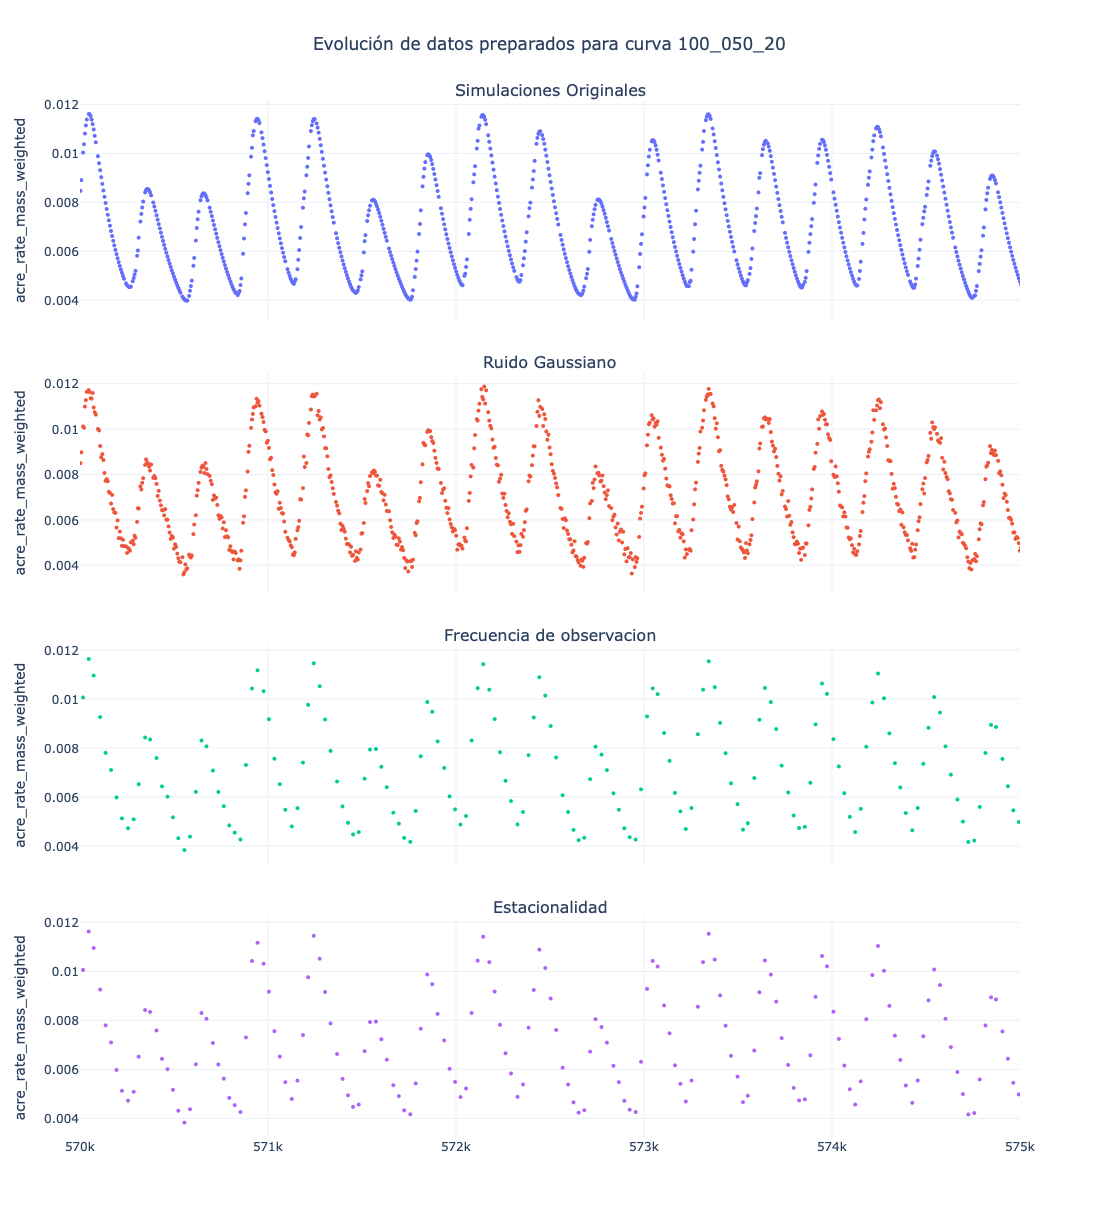

In [23]:
# Supongamos que ya tienes df1, df2, df3, df4 y que quieres comparar estos IDs:

dfs = [all_data, noisy_df, df_unique, df_unique]


plot_id_across_dfs(
    dfs,
    "100_050_20",
    x_range=(570000, 575000)
)


In [24]:
import numpy as np
import pandas as pd

clave = ['id']

all_data['week_idx'] = (all_data['time_days'] // 7).astype(int)

obs_per_week = (
    all_data
      .groupby(clave + ['week_idx'], as_index=False)
      .size()                                    # cuenta filas
      .rename(columns={'size': 'obs'})
)

full_weeks = (
    all_data.groupby(clave)['week_idx']
            .agg(['min', 'max'])                 # rango de semanas presentes
            .apply(lambda r: range(int(r['min']), int(r['max']) + 1), axis=1)
            .explode()
            .reset_index()
            .rename(columns={0: 'week_idx'})
)

coverage = (
    full_weeks
      .merge(obs_per_week, on=clave + ['week_idx'], how='left')
      .fillna({'obs': 0})                       # semanas sin datos → 0 obs
)

stats = (
    coverage
      .groupby(clave, as_index=False)
      .agg(
          weeks_total   = ('week_idx', 'size'),
          weeks_no_data = ('obs', lambda x: (x == 0).sum()),
          obs_totales   = ('obs', 'sum'),
      )
)

stats['obs_por_semana_prom'] = stats['obs_totales'] / stats['weeks_total']
stats['porc_sem_sin_datos']  = stats['weeks_no_data'] / stats['weeks_total']



In [27]:
df_unique.to_csv(CSV_NOISY, index=False)